In [49]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt # check the code posted
import numpy as np
import time

#quello che ti interessa è il train loss che mi dice andamento convergenza e accuratezza su tes perché è il nostro obiettivo, il resto ci interessa relativamente

In [50]:
device = torch.device("cuda") # to use the GPU
epochs = 10

batch_size = 64
transform=transforms.Compose([
    # here goes augmentation
        transforms.ToTensor(), # dim of new tensor: #batch, #channel_in, #height, #width
        transforms.Normalize((0.1307,), (0.3081,))#mean and std
        #come calcolo 0.13? 
        # 1) prendo il dataset con la sola trasformazione toTensor()
        # 2) su tutte matrici dataset ha fatto somma e ci ha fatto media
        # dalla matrice ha estratto valor medio e l ha fatto su tutte le matrici
        #... stessa cosa per std
      ])
dataset1 = datasets.MNIST('data', train=True, download=True, transform=transform)#la transformazione non viene applicata qui, solo a runtime sul dataloader
dataset2 = datasets.MNIST('data', train=False, transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1, num_workers=1, pin_memory=True,shuffle=True,batch_size=batch_size)#data augmentation solo per training, non so TEST!!
test_loader = torch.utils.data.DataLoader(dataset2, num_workers=1, pin_memory=True,shuffle=True,batch_size=batch_size)

for batch in train_loader:
    images, labels = batch
    print(images.shape)  # Shape of the image batch
    print(labels.shape)  # Shape of the label batch
    break  # Just to inspect the first batch and stop the loop

torch.Size([64, 1, 28, 28])
torch.Size([64])


HOW to compute mean and std of a dataset

In [51]:
import torch
from torchvision import datasets, transforms

# Step 1: Load the dataset with only ToTensor applied
transform = transforms.ToTensor()
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Step 2: Compute mean and standard deviation
loader = torch.utils.data.DataLoader(train_data, batch_size=60000, shuffle=False)
data = next(iter(loader))[0]  # Take all the images from the dataset

mean = data.mean()
std = data.std()

print(f'Mean: {mean}, Std: {std}')

Mean: 0.13066048920154572, Std: 0.30810782313346863


In [52]:
class Net(nn.Module):
    def __init__(self):
        """ from torch.docs
            torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1,
                            groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)
        """
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1) #putput dimension is 32
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # x.shape B, N, H, W
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)#ll_loss
        return output


In [53]:
import numpy as np
    
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    losses = []
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()#considera di annullarlo ancge prima della fine dell epoca
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        
        if batch_idx % 500 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
        
        losses.append(loss.item())
    
    return np.mean(losses)  # Return just the mean of the losses


In [54]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_accuracy = correct / len(test_loader.dataset)
    return test_loss, test_accuracy

## Exercise 0: Plot of the values of the training/test losses and training accuracies/test.

This can help to monitor how the training is going.

In [55]:
import matplotlib.pyplot as plt
import numpy as np
import time

def train_test_plot(model, device, train_loader, test_loader, optimizer, epochs):
    train_loss = []
    test_loss = []
    test_accuracy = []
    epoch_list = []
    epoch_times = []  # List to store execution times

    overall_start_time = time.time()  # Start overall timer

    for epoch in range(1, epochs + 1):
        start_time = time.time()  # Start timer for the epoch
        
        epoch_list.append(epoch)
        train_loss.append(train(model, device, train_loader, optimizer, epoch))
        
        test_l, accuracy = test(model, device, test_loader)
        test_loss.append(test_l)
        test_accuracy.append(accuracy)  # Track the test accuracy
        
        end_time = time.time()  # End timer for the epoch
        epoch_times.append(end_time - start_time)  # Record time for the epoch
        
    overall_end_time = time.time()  # End overall timer
    total_execution_time = overall_end_time - overall_start_time  # Calculate total time

    # Plot the train and test loss
    plt.figure(figsize=(10, 7))

    # Loss plot
    plt.subplot(2, 1, 1)  # Two rows, one column, first plot
    plt.plot(epoch_list, train_loss, label='Train Loss', color='blue')
    plt.plot(epoch_list, test_loss, label='Test Loss', color='red')

    plt.title('Training and Testing Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy plot
    plt.subplot(2, 1, 2)  # Two rows, one column, second plot
    plt.plot(epoch_list, test_accuracy, label='Test Accuracy', color='green')
    plt.title('Testing Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Show both plots
    plt.tight_layout()
    plt.show()

    # Print the total execution time
    print(f"Total Execution Time: {total_execution_time:.2f} seconds")


## CNN original

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.304502
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.049918

Test set: Average loss: 0.0626, Accuracy: 9804/10000 (98%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.299949
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.030564

Test set: Average loss: 0.0422, Accuracy: 9861/10000 (99%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.058325
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.027296

Test set: Average loss: 0.0876, Accuracy: 9730/10000 (97%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.161590
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.018003

Test set: Average loss: 0.0369, Accuracy: 9881/10000 (99%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.000735
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.000900

Test set: Average loss: 0.0327, Accuracy: 9894/10000 (99%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.007264
Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.000662

Test set: Average loss: 0.2476, Accuracy: 9497/10000 (95%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.181520
Train Epoch: 7 [320

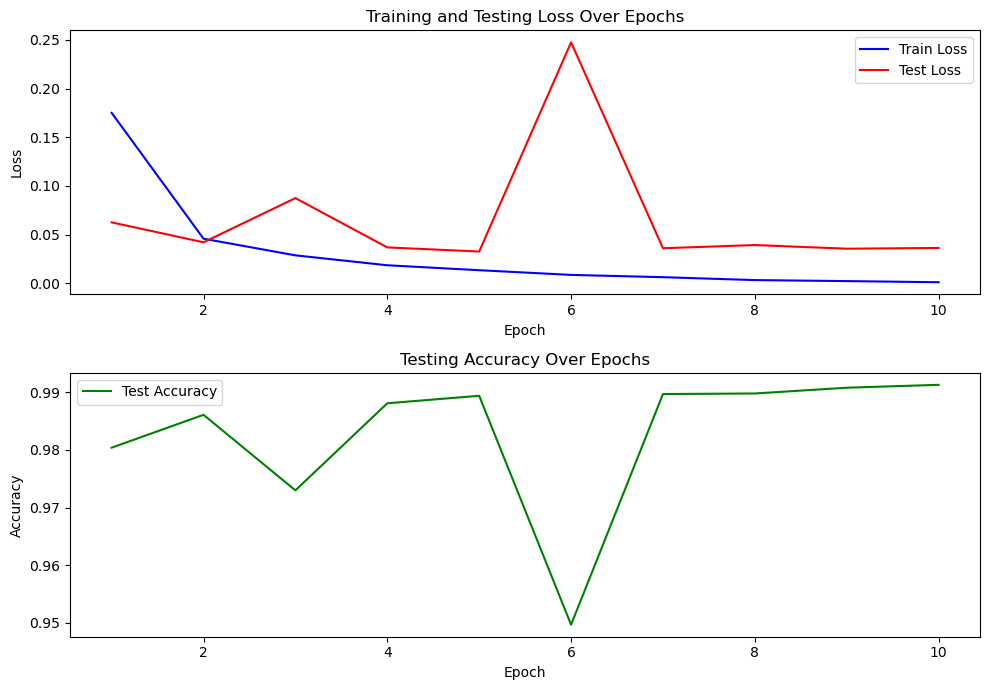

Total Execution Time: 111.43 seconds


In [56]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), 0.1)

train_test_plot(model, device, train_loader, test_loader, optimizer, epochs)

## Linear model

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.406867
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.269519

Test set: Average loss: 0.0986, Accuracy: 9701/10000 (97%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.154996
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.167914

Test set: Average loss: 0.0824, Accuracy: 9738/10000 (97%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.085801
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.016164

Test set: Average loss: 0.0804, Accuracy: 9757/10000 (98%)



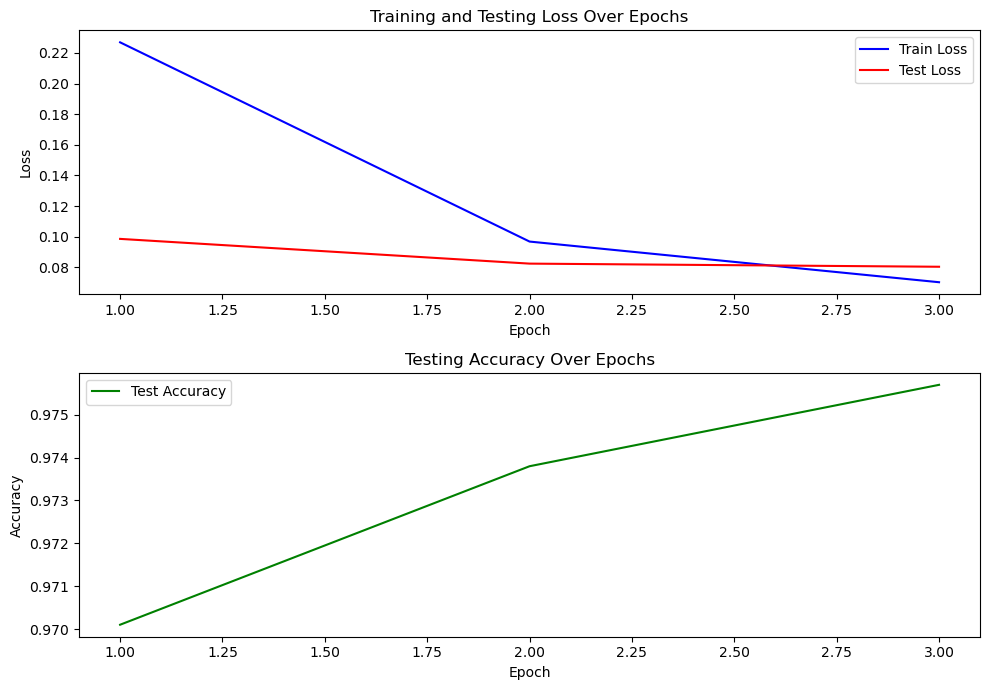

Total Execution Time: 32.65 seconds
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.422769
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.093182

Test set: Average loss: 0.1025, Accuracy: 9692/10000 (97%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.050376
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.068936

Test set: Average loss: 0.0970, Accuracy: 9692/10000 (97%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.068897
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.009492

Test set: Average loss: 0.0775, Accuracy: 9763/10000 (98%)



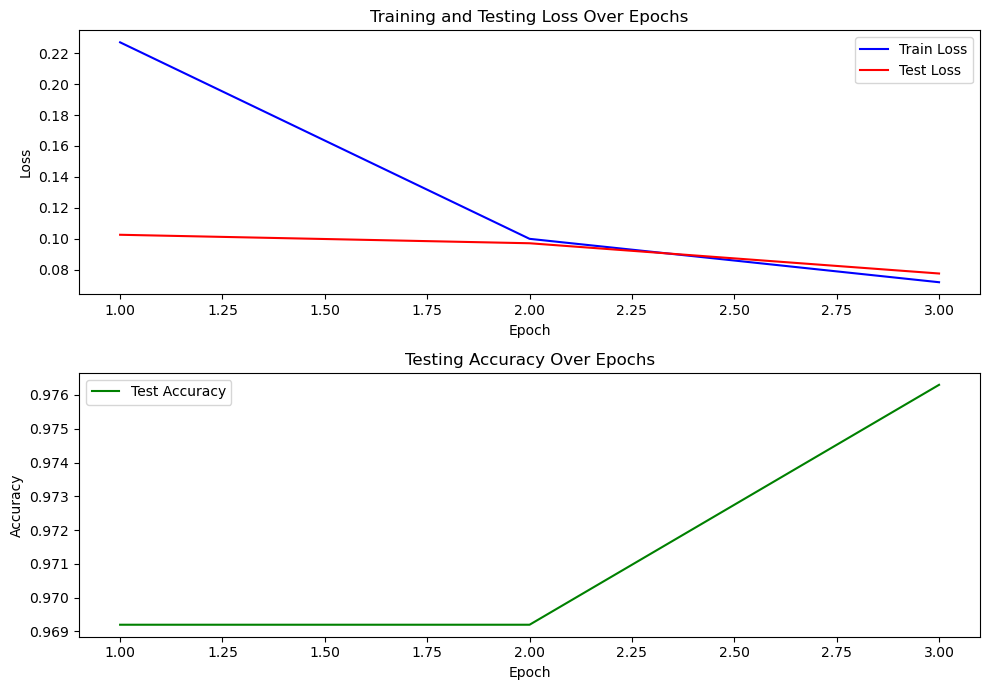

Total Execution Time: 31.90 seconds


In [57]:
class Net_Linear_with_bias(nn.Module):#try without bias, here you have bias default so true
    def __init__(self):
        super(Net_Linear_with_bias, self).__init__()
        self.l1 = nn.Linear(784, 128) #putput dimension is 32
        self.l2 = nn.Linear(128, 64)

        self.lend = nn.Linear(64, 10)

        self.bn1 = nn.BatchNorm1d(128)
        self.bn2 = nn.BatchNorm1d(64)


    def forward(self, x):
        # x.shape B, N, H, W
        x = torch.flatten(x, 1)
        x = self.l1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.l2(x)
        x = self.bn2(x)
        x = F.relu(x)          
        x = self.lend(x)
        output = F.log_softmax(x, dim=1)
        return output
    
epochs = 3
model = Net_Linear_with_bias().to(device)
optimizer = optim.SGD(model.parameters(), 0.1)
train_test_plot(model, device, train_loader, test_loader, optimizer, epochs)


class Net_Linear_NO_bias(nn.Module):#try without bias, here you have bias default so true
    def __init__(self):
        super(Net_Linear_NO_bias, self).__init__()
        self.l1 = nn.Linear(784, 128) #putput dimension is 32
        self.l2 = nn.Linear(128, 64)

        self.lend = nn.Linear(64, 10, bias=False)

        self.bn1 = nn.BatchNorm1d(128)
        self.bn2 = nn.BatchNorm1d(64)


    def forward(self, x):
        # x.shape B, N, H, W
        x = torch.flatten(x, 1)
        x = self.l1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.l2(x)
        x = self.bn2(x)
        x = F.relu(x)          
        x = self.lend(x)
        output = F.log_softmax(x, dim=1)
        return output
    
epochs = 3
model = Net_Linear_NO_bias().to(device)
optimizer = optim.SGD(model.parameters(), 0.1)
train_test_plot(model, device, train_loader, test_loader, optimizer, epochs)


# Linear with more parameters or deeper structure

In [59]:
class Net_Linear_deeper(nn.Module):#try without bias, here you have bias default so true
    def __init__(self):
        super(Net_Linear_deeper, self).__init__()
        self.l1 = nn.Linear(784, 64) #putput dimension is 32
        self.l2 = nn.Linear(64, 64)
        self.l3 = nn.Linear(64, 64)
        self.l4 = nn.Linear(64, 64)
        self.l5 = nn.Linear(64, 64)
        self.l6 = nn.Linear(64, 64)
        self.l7 = nn.Linear(64, 64)
        self.l8 = nn.Linear(64, 64)
        self.l9 = nn.Linear(64, 64)
        self.lend = nn.Linear(64, 10, bias=False)

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(64)
        self.bn3 = nn.BatchNorm1d(64)
        self.bn4 = nn.BatchNorm1d(64)
        self.bn5 = nn.BatchNorm1d(64)
        self.bn6 = nn.BatchNorm1d(64)
        self.bn7 = nn.BatchNorm1d(64)
        self.bn8 = nn.BatchNorm1d(64)
        self.bn9 = nn.BatchNorm1d(64)
        self.bn10 = nn.BatchNorm1d(64)


    def forward(self, x):
        # Flatten the input
        x = torch.flatten(x, 1)  # Flatten the input to shape (batch_size, 784)

        # Pass through each layer with batch normalization and ReLU
        x = self.bn1(self.l1(x))  # Linear + BatchNorm
        x = F.relu(x)             # ReLU activation
        
        x = self.bn2(self.l2(x))
        x = F.relu(x)
        
        x = self.bn3(self.l3(x))
        x = F.relu(x)

        x = self.bn4(self.l4(x))
        x = F.relu(x)

        x = self.bn5(self.l5(x))
        x = F.relu(x)

        x = self.bn6(self.l6(x))
        x = F.relu(x)

        x = self.bn7(self.l7(x))
        x = F.relu(x)

        x = self.bn8(self.l8(x))
        x = F.relu(x)

        x = self.bn9(self.l9(x))
        x = F.relu(x)

        # Final layer (no batch normalization and no ReLU)
        x = self.lend(x)  # No bias here
        output = F.log_softmax(x, dim=1)  # Log softmax for output
    
epochs = 3
model = Net_Linear_deeper().to(device)
optimizer = optim.SGD(model.parameters(), 0.1)
train_test_plot(model, device, train_loader, test_loader, optimizer, epochs)

TypeError: nll_loss_nd(): argument 'input' (position 1) must be Tensor, not NoneType

In [60]:
class Net_Linear_wider(nn.Module):#try without bias, here you have bias default so true
    def __init__(self):
        super(Net_Linear_wider, self).__init__()
        self.l1 = nn.Linear(784, 256) #putput dimension is 32
        self.l2 = nn.Linear(256, 256*2)
        self.l3 = nn.Linear(256*2, 256)
        self.l4 = nn.Linear(256, 64)
        self.l5 = nn.Linear(64, 10)

        self.bn1 = nn.BatchNorm1d(256)
        self.bn2 = nn.BatchNorm1d(256*2)
        self.bn3 = nn.BatchNorm1d(256)
        self.bn4 = nn.BatchNorm1d(64)



    def forward(self, x):
        # Flatten the input
        x = torch.flatten(x, 1)  # Flatten the input to shape (batch_size, 784)

        # Pass through each layer with batch normalization and ReLU
        x = self.bn1(self.l1(x))  # Linear + BatchNorm
        x = F.relu(x)             # ReLU activation

        x = self.bn2(self.l2(x))
        x = F.relu(x)

        x = self.bn3(self.l3(x))
        x = F.relu(x)

        x = self.bn4(self.l4(x))
        x = F.relu(x)

        # Final layer (no activation)
        x = self.l5(x)  # No batch normalization or activation for the final layer
        output = F.log_softmax(x, dim=1)  # Log softmax for output
    
epochs = 3
model = Net_Linear_wider().to(device)
optimizer = optim.SGD(model.parameters(), 0.1)
train_test_plot(model, device, train_loader, test_loader, optimizer, epochs)

TypeError: nll_loss_nd(): argument 'input' (position 1) must be Tensor, not NoneType

## Exercise 1

Try to change the network architecture (e.g. use all linear layers) or network hyperparameters (e.g. dimensions of the CNN kernel, stride, padding)

How the performance change? Why?

##controlla con diverso numero di layer per ogni tipo di rete


#lr == 0.03 o 0.01 perché mnist senno esagera con sgd, con adam va bene 0.0003 o 0.0001 con 15 o 30 epoche


cosa succede con + o - layer? x linear
conviene fare + layer stretti o meno layer + larghi?

In [25]:
class Net_Linear_with_bias(nn.Module):#try without bias, here you have bias default so true
    def __init__(self):
        super(Net_Linear_with_bias, self).__init__()
        self.l1 = nn.Linear(28*28, 256) #putput dimension is 32
        self.l2 = nn.Linear(256, 256*2)
        self.l3 = nn.Linear(256*2, 256)
        self.l4 = nn.Linear(256, 64)
        self.lend = nn.Linear(64, 10, bias=False)

        self.bn1 = nn.BatchNorm1d(256)
        self.bn2 = nn.BatchNorm1d(256*2)
        self.bn3 = nn.BatchNorm1d(256)
        self.bn4 = nn.BatchNorm1d(64)

    def forward(self, x):
        # x.shape B, N, H, W
        x = torch.flatten(x, 1)
        x = self.l1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.l2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.l3(x)
        x = self.bn3(x)
        x = F.relu(x)  
        x = self.l4(x)   
        x = self.bn4(x)
        x = F.relu(x)          
        x = self.lend(x)
        output = F.log_softmax(x, dim=1)
        return output
    
epochs = 3

model = Net_Linear_with_bias().to(device)
optimizer = optim.SGD(model.parameters(), 0.1)

train_test_plot(model, device, train_loader, test_loader, optimizer, epochs)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.355878
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.138959

Test set: Average loss: 0.0897, Accuracy: 9718/10000 (97%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.124676
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.154625

Test set: Average loss: 0.0703, Accuracy: 9771/10000 (98%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.040782
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.024005


KeyboardInterrupt: 

## CNN

In [ ]:
class Net_avg_pool(nn.Module):
    def __init__(self):
        """ from torch.docs
            torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1,
                            groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)
        """
        super(Net_avg_pool, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1) #putput dimension is 32
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # x.shape B, N, H, W
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.avg_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)#ll_loss
        return output



model = Net_avg_pool().to(device)
optimizer = optim.SGD(model.parameters(), 0.1)

train_test_plot(model, device, train_loader, test_loader, optimizer, epochs)

In [32]:
class Net_stride(nn.Module):
    def __init__(self):
        super(Net_stride, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)  # Output size: (batch_size, 32, 26, 26)
        self.conv2 = nn.Conv2d(32, 64, 3, 2) # Output size: (batch_size, 64, 12, 12)
        self.fc1 = nn.Linear(2304, 128)      # Corrected input size
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.avg_pool2d(x, 2)  # Output size: (batch_size, 64, 6, 6)
        x = torch.flatten(x, 1)  # Flatten to (batch_size, 2304)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)  # Log softmax for output
        return output

# Example usage:
model = Net_stride().to(device)
optimizer = optim.SGD(model.parameters(), 0.1)

train_test_plot(model, device, train_loader, test_loader, optimizer, epochs)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.305570
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.081205

Test set: Average loss: 0.0792, Accuracy: 9751/10000 (98%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.108275
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.043813

Test set: Average loss: 0.0469, Accuracy: 9846/10000 (98%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.123495
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.008459


KeyboardInterrupt: 

#    #cosa cambia da usare maxpooling p avarage piuttosto che fare degli strinde con kernel , usa numero piccolo di epoche, non + di 10

In [34]:
class Net_bigger_kernel(nn.Module):
    def __init__(self):
        """ from torch.docs
            torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1,
                            groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)
        """
        super(Net_bigger_kernel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1) #putput dimension is 32
        self.conv2 = nn.Conv2d(32, 64, 5, 1)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # x.shape B, N, H, W
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = torch.avg_pool1d(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)#ll_loss
        return output


epochs = 3

model = Net_bigger_kernel().to(device)
optimizer = optim.SGD(model.parameters(), 0.1)

train_test_plot(model, device, train_loader, test_loader, optimizer, epochs)


RuntimeError: Expected 2 to 3 dimensions, but got 4-dimensional tensor for argument #1 'self' (while checking arguments for avg_pool1d)

usare un fully connected porta a risultati pessimi

In [11]:

class Net3(nn.Module):
    def __init__(self):
        """ from torch.docs
            torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1,
                            groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)
        """
        super(Net3, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 5, 1,1) #putput dimension is 32
        self.conv2 = nn.Conv2d(32, 64, 5, 1,1)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # x.shape B, N, H, W
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output
    


model = Net3().to(device)
optimizer = optim.SGD(model.parameters(), 0.1)

for epoch in range(1, epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.316719
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.073173

Test set: Average loss: 0.0735, Accuracy: 9753/10000 (98%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.022722
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.014350

Test set: Average loss: 0.0371, Accuracy: 9874/10000 (99%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.033630
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.022604

Test set: Average loss: 0.0324, Accuracy: 9884/10000 (99%)



## Exercise 2

Try to work with the hyperparameters (batch_size, learning_rate, ...).

In particular try to focus on the optimization part. Change algorithm, momentum, parameters...

Please refer to https://pytorch.org/docs/stable/optim.html to see how to set all the parameters

How can it be improved?

In [12]:
epochs=30

model = Net().to(device)
optimizer = optim.SGD(model.parameters(), 0.01,momentum=0.9)

for epoch in range(1, epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.304300
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.157849

Test set: Average loss: 0.1163, Accuracy: 9676/10000 (97%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.105591
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.057471

Test set: Average loss: 0.0808, Accuracy: 9777/10000 (98%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.002404
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.018602

Test set: Average loss: 0.0838, Accuracy: 9757/10000 (98%)



In [13]:

model = Net().to(device)
optimizer = optim.SGD(model.parameters(), 0.01)

for epoch in range(1, epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.299151
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.273558

Test set: Average loss: 0.1833, Accuracy: 9467/10000 (95%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.307525
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.238257

Test set: Average loss: 0.1122, Accuracy: 9660/10000 (97%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.054562
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.081454

Test set: Average loss: 0.0885, Accuracy: 9721/10000 (97%)



In [14]:
model = Net().to(device)
optimizer = optim.Adam(model.parameters(), 0.0001)

for epoch in range(1, epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.291000
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.034829

Test set: Average loss: 0.0903, Accuracy: 9713/10000 (97%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.068457
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.095891

Test set: Average loss: 0.0860, Accuracy: 9727/10000 (97%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.108876
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.064182

Test set: Average loss: 0.0992, Accuracy: 9728/10000 (97%)



In [48]:
epochs = 30
model = Net_Linear_wider().to(device)
optimizer = optim.SGD(model.parameters(), 0.01)
train_test_plot(model, device, train_loader, test_loader, optimizer, epochs)

TypeError: nll_loss_nd(): argument 'input' (position 1) must be Tensor, not NoneType

In [ ]:
epochs = 30
model = Net_Linear_wider().to(device)
optimizer = optim.adam(model.parameters(), 0.0001)
train_test_plot(model, device, train_loader, test_loader, optimizer, epochs)

In [15]:
l1_lambda = 1e-5  # Regularization strength

for epoch in range(1, epochs + 1):
    model.train()
    running_loss = 0.0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()

        output = model(data)
        loss = F.nll_loss(output, target)

        # L1 regularization using torch.norm with p=1 for L1
        l1_norm = sum(torch.norm(p, 1) for p in model.parameters())
        loss = loss + l1_lambda * l1_norm  # Add L1 term to the loss

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch: {epoch}, Loss: {running_loss / len(train_loader)}")
    test(model, device, test_loader)


Epoch: 1, Loss: 0.2499221060226467

Test set: Average loss: 0.1055, Accuracy: 9684/10000 (97%)

Epoch: 2, Loss: 0.20411452881372305

Test set: Average loss: 0.0881, Accuracy: 9743/10000 (97%)

Epoch: 3, Loss: 0.21567557340682442

Test set: Average loss: 0.0823, Accuracy: 9767/10000 (98%)

